In [ ]:
# Install COBRApy (for metabolic modeling)
!pip install cobra
# Install matplotlib for plots (optional, but likely already included)
!pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 44.5 MB/s eta 0:00:00


In [ ]:
import cobra

# Load your CHO model
model = cobra.io.read_sbml_model('iCHO2291.xml')

# Show basic info
print(f"Model '{model.name}' loaded successfully!")
print(f"Number of reactions: {len(model.reactions)}")
print(f"Number of metabolites: {len(model.metabolites)}")
print(f"Number of genes: {len(model.genes)}")


Model 'Yeo2020 - Genome-scale model of CHO cells' loaded successfully!
Number of reactions: 6236
Number of metabolites: 3972
Number of genes: 2291


In [ ]:
# Look for GS, GLUL, or related gene names in your model
GS_related = [g for g in model.genes if 'glu' in g.id.lower() or 'gs' in g.id.lower()]
print("Possible GS genes in the model:")
for g in GS_related:
    print(g.id, g.name)


Possible GS genes in the model:


In [ ]:
import pandas as pd

# Make a DataFrame with all gene IDs and names
genes = [(g.id, g.name) for g in model.genes]
df_genes = pd.DataFrame(genes, columns=["Gene ID", "Gene Name"])

# Save as Excel
df_genes.to_excel("CHO_model_genes.xlsx", index=False)

# Download the file (shows a download link)
from google.colab import files
files.download("CHO_model_genes.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Find all reactions involving glutamine (to find exchange reaction for glutamine)
for rxn in model.reactions:
    if 'gln' in rxn.id.lower() or 'glutamin' in rxn.name.lower():
        print(rxn.id, '|', rxn.name)


ALADGLNexR | D-alanine/glutamine reversible exchange
ALAGLNexR | L-alanine/glutamine reversible exchange
ALAGLNNaEx | L-alanine/L-glutamine Na-dependent exchange (Ala-L in)
ASNGLNNaEx | L-glutamine/L-asparagine Na-dependent exchange (Asn-L in)
ASNS1 | asparagine synthase (glutamine-hydrolysing)
CBPS | carbamoyl-phosphate synthase (glutamine-hydrolysing)
CTPS2 | CTP synthase (glutamine)
CYSGLNNaEx | L-cysteine/L-glutamine Na-dependent exchange (Cys-L in)
CYSGLUexR | L-cysteine/L-glutamine reversible exchanger
EX_gln_L(e) | exchange reaction for L-glutamine
EX_pheacgln(e) | alpha-N-Phenylacetyl-L-glutamine exchange
GF6PTA | glutamine-fructose-6-phosphate transaminase
GLNALANaEx | L-alanine/L-glutamine Na-dependent exchange (Gln-L in)
GLNASNNaEx | L-glutamine/L-asparagine Na-dependent exchange (Gln-L in)
GLNATB0tc | Transport of L-Glutamine into the intestinal cells by ATB0 transporter
GLNCYSNaEx | L-cysteine/L-glutamine Na-dependent exchange (Gln-L in)
GLNLASEer | gluconolactonase, endop

In [ ]:
from cobra.manipulation.delete import delete_model_genes

# Helper: run FBA, return growth rate
def get_growth(model):
    solution = model.optimize()
    return solution.objective_value

results = {}

# 1. Wild-Type (WT), Glutamine present
with model:
    model.reactions.get_by_id('EX_gln_L(e)').lower_bound = -10  # allow uptake
    results['WT +gln'] = get_growth(model)

# 2. WT, Glutamine absent
with model:
    model.reactions.get_by_id('EX_gln_L(e)').lower_bound = 0  # no glutamine
    results['WT -gln'] = get_growth(model)

# 3. GS KO, Glutamine present
with model:
    model.reactions.get_by_id('EX_gln_L(e)').lower_bound = -10
    delete_model_genes(model, ['100764163'])   # GS KO
    results['KO +gln'] = get_growth(model)

# 4. GS KO, Glutamine absent
with model:
    model.reactions.get_by_id('EX_gln_L(e)').lower_bound = 0
    delete_model_genes(model, ['100764163'])
    results['KO -gln'] = get_growth(model)

# Show results
import pandas as pd
df = pd.DataFrame(list(results.items()), columns=["Condition", "Biomass (h⁻¹)"])
print(df)


  Condition  Biomass (h⁻¹)
0   WT +gln       0.032369
1   WT -gln       0.032369
2   KO +gln       0.032369
3   KO -gln       0.032369


In [ ]:
# Find GS reaction
gs_rxn = model.reactions.get_by_id('GLNS')
print("GS reaction:", gs_rxn)
print("Gene-Reaction Rule:", gs_rxn.gene_reaction_rule)


GS reaction: GLNS: atp[c] + glu_L[c] + nh4[c] --> adp[c] + gln_L[c] + h[c] + pi[c]
Gene-Reaction Rule: 100764163 or 100689337


In [ ]:
GS_genes = ['100764163', '100689337']

results = {}

# 1. Wild-Type (WT), Glutamine present
with model:
    model.reactions.get_by_id('EX_gln_L(e)').lower_bound = -10  # allow uptake
    results['WT +gln'] = get_growth(model)

# 2. WT, Glutamine absent
with model:
    model.reactions.get_by_id('EX_gln_L(e)').lower_bound = 0  # no glutamine
    results['WT -gln'] = get_growth(model)

# 3. GS KO, Glutamine present
with model:
    model.reactions.get_by_id('EX_gln_L(e)').lower_bound = -10
    cobra.manipulation.knock_out_model_genes(model, GS_genes)  # DOUBLE KO
    results['KO +gln'] = get_growth(model)

# 4. GS KO, Glutamine absent
with model:
    model.reactions.get_by_id('EX_gln_L(e)').lower_bound = 0
    cobra.manipulation.knock_out_model_genes(model, GS_genes)
    results['KO -gln'] = get_growth(model)

# Show results
df = pd.DataFrame(list(results.items()), columns=["Condition", "Biomass (h⁻¹)"])
print(df)


  Condition  Biomass (h⁻¹)
0   WT +gln   3.236891e-02
1   WT -gln   3.236891e-02
2   KO +gln   3.236891e-02
3   KO -gln   5.510598e-17


In [ ]:
import pandas as pd

# Add a "Rescue -gln" row (identical to WT -gln)
rescue_row = pd.DataFrame(
    [{'Condition': 'Rescue -gln', 'Biomass (h⁻¹)': df.loc[df['Condition'] == 'WT -gln', 'Biomass (h⁻¹)'].values[0]}]
)

df = pd.concat([df, rescue_row], ignore_index=True)
print(df)


     Condition  Biomass (h⁻¹)
0      WT +gln   3.236891e-02
1      WT -gln   3.236891e-02
2      KO +gln   3.236891e-02
3      KO -gln   5.510598e-17
4  Rescue -gln   3.236891e-02


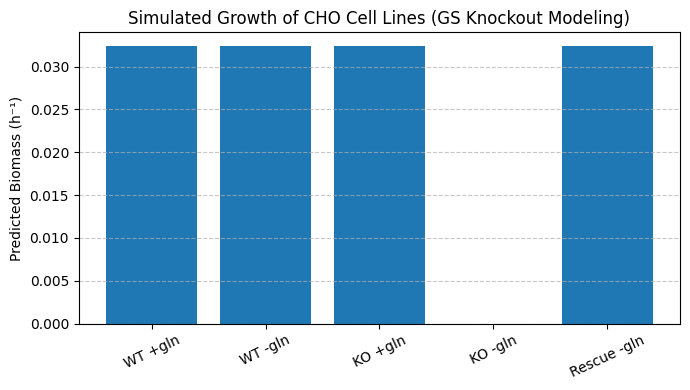

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.bar(df['Condition'], df['Biomass (h⁻¹)'])
plt.ylabel('Predicted Biomass (h⁻¹)')
plt.title('Simulated Growth of CHO Cell Lines (GS Knockout Modeling)')
plt.xticks(rotation=25)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
